# Serial simulation

In [1]:
import logging
import sys

root = logging.getLogger()
root.setLevel(logging.DEBUG)

In [2]:
import numpy as np
from decimal import Decimal

In [3]:
from latticemc.definitions import Lattice, LatticeState, OrderParametersHistory, DefiningParameters
from latticemc.lattice_tools import initialize_partially_ordered
from latticemc.random_quaternion import random_quaternion
from latticemc.updaters import Updater, OrderParametersCalculator, FluctuationsCalculator, DerivativeWiggleRateAdjustor, RandomWiggleRateAdjustor, CallbackUpdater, AcceptanceRateWiggleRateAdjustor
from latticemc.failsafe import failsafe_save_simulation
from latticemc.parallel import SimulationRunner
from latticemc import simulation_numba

In [4]:
lattice = Lattice(9, 9, 9)
initialize_partially_ordered(lattice, x=random_quaternion(1))

model_params = DefiningParameters(temperature=Decimal(0.9), lam=Decimal(0.3), tau=Decimal(1))
state = LatticeState(parameters=model_params, lattice=lattice)
order_parameters_history = {model_params: OrderParametersHistory()}

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display

def plot_progress(state: LatticeState, max_window: float, step: int):
    op = order_parameters_history[state.parameters].order_parameters
    fig,ax = plt.subplots(3)
    fig.tight_layout()
    fig.set_size_inches(10,10)
    start = step if op.size < max_window else (op.size-max_window)
    size = op.size if op.size < max_window else max_window
    x = np.linspace(start, start+size, size//step-1)
    ax[0].plot(x, op['energy'][start::step], label='energy')
    ax[1].plot(x, op['p'][start::step], label='p')
    ax[1].plot(x, op['q0'][start::step], label='q0')
    ax[1].plot(x, op['q2'][start::step], label='q2')
    ax[1].plot(x, op['d322'][start::step], label='d322')
    ax[2].plot(x, op['w'][start::step], label='w')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    display.display(fig)
    display.clear_output(wait=True)
    plt.close(fig)  # Close figure to prevent memory leaks

In [6]:
order_parameters_calculator = OrderParametersCalculator(order_parameters_history[model_params], how_often=1, since_when=1)#, printEvery=50)
fluctuations_calculator = FluctuationsCalculator(order_parameters_history[model_params], window=100, how_often=50, since_when=100)#, printEvery=50)
updaters = [
    order_parameters_calculator,
    fluctuations_calculator,
    CallbackUpdater(lambda state: plot_progress(state, step=10, max_window=10000), how_often=100, since_when=10),
    AcceptanceRateWiggleRateAdjustor(how_often=100, since_when=10),
    # DerivativeWiggleRateAdjustor(order_parameters_history=order_parameters_history[model_params], how_many=100, how_often=10, since_when=101),
    RandomWiggleRateAdjustor(scale=0.001, how_often=10, since_when=1),
    RandomWiggleRateAdjustor(scale=1.0, reset_value=1.0, how_often=1000, since_when=1000),
]

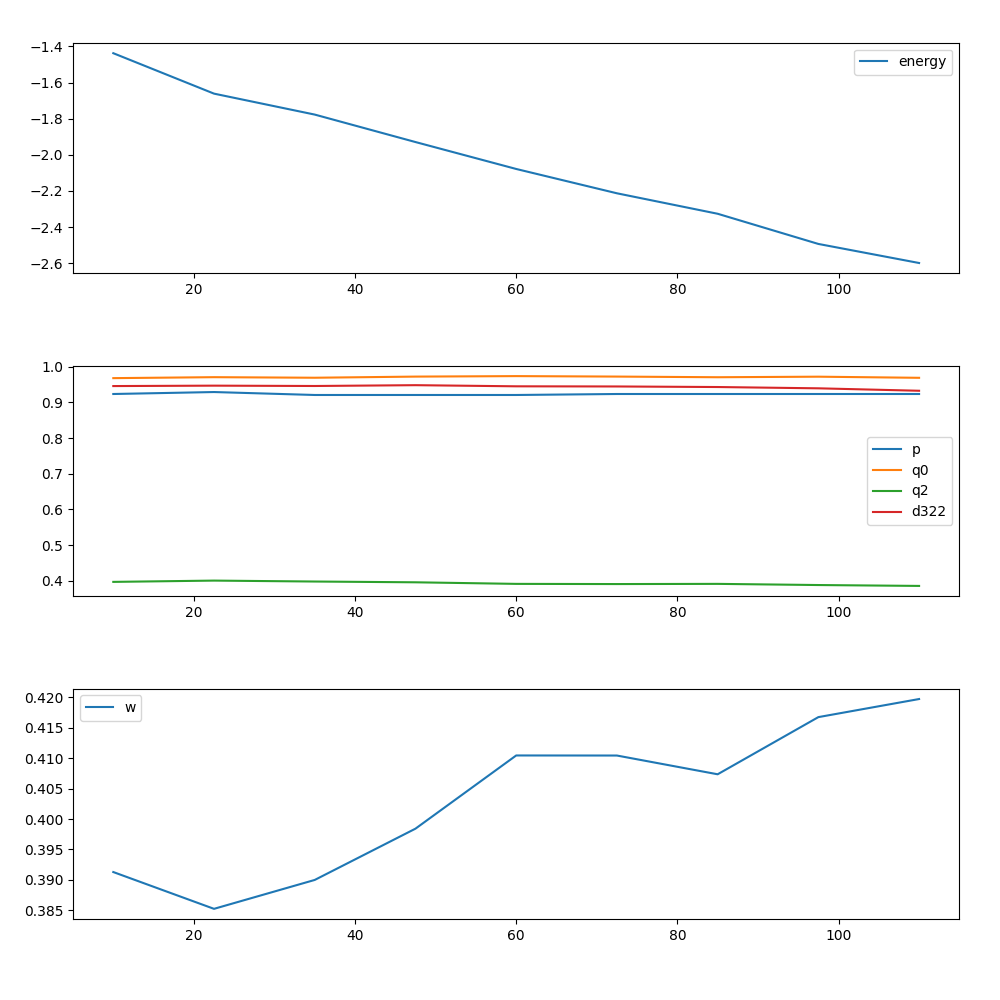

In [7]:
for it in range(100):
    simulation_numba.do_lattice_state_update(state)

    for u in updaters:
        u.perform(state)

# Parallel simulations

**WARNING**: The simulation will create as many subprocesses as there are temperatures. This will use a lot of memory. Expect crashes!

These settings should run fine on an 8-core processor with 16GB of RAM.

In [7]:
temperatures = np.arange(0.4, 1.7, 0.05)
states = [LatticeState(parameters=DefiningParameters(temperature=round(Decimal(t), 2), lam=Decimal(0.3), tau=1),
                       lattice=Lattice(10, 10, 10))
          for t in temperatures]
for state in states:
    initialize_partially_ordered(state.lattice, x=random_quaternion(1.0))

order_parameters_history = {state.parameters: OrderParametersHistory() for state in states}

In [8]:
per_state_updaters = [
    #DerivativeWiggleRateAdjustor(howMany=100, how_often=10, since_when=100),
    AcceptanceRateWiggleRateAdjustor(how_often=100, since_when=10),
    RandomWiggleRateAdjustor(scale=0.001, how_often=10, since_when=10),
    RandomWiggleRateAdjustor(scale=1.0, reset_value=1.0, how_often=1000, since_when=1000)
]

runner = SimulationRunner(states,
                          order_parameters_history,
                          cycles=1000000,
                          report_order_parameters_every=10,
                          report_state_every=1000,
                          per_state_updaters=per_state_updaters,
                          parallel_tempering_interval=10)
runner.start()

In [10]:
temperatures

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6])

In [9]:
%matplotlib inline
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend for VS Code compatibility
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
import time

class Plotter:
    def __init__(self, temperatures, order_parameters_history, window=1000):
        self.order_parameters_history = order_parameters_history
        self.x = [float(t) for t in temperatures]
        self.energy = [0 for _ in self.x]
        self.specific_heat = [0 for _ in self.x]
        self.q0 = [0 for _ in self.x]
        self.q2 = [0 for _ in self.x]
        self.par = [0 for _ in self.x]
        self.d322 = [0 for _ in self.x]
        self.w = [0 for _ in self.x]
        self.window = window
        self.fig = None
        self.ax = None
        self.lines = []
        
        # Initialize the plot
        self.setup_plot()
        
    def setup_plot(self):
        if(self.fig is not None):
            plt.close(self.fig)
    
        self.fig, self.ax = plt.subplots(2, figsize=(10, 12))
        
        # Initialize empty lines
        line1, = self.ax[0].plot(self.x, self.energy, label='energy', marker='o', linestyle='-')
        line2, = self.ax[0].plot(self.x, self.specific_heat, label='specific_heat', marker='s', linestyle='-')
        line3, = self.ax[1].plot(self.x, self.q0, label='q0', marker='o', linestyle='-')
        line4, = self.ax[1].plot(self.x, self.q2, label='q2', marker='s', linestyle='-')
        line5, = self.ax[1].plot(self.x, self.par, label='p', marker='^', linestyle='-')
        line6, = self.ax[1].plot(self.x, self.d322, label='d322', marker='v', linestyle='-')
        
        self.lines = [line1, line2, line3, line4, line5, line6]
        
        self.ax[0].set_xlabel('Temperature')
        self.ax[0].set_ylabel('Energy / Specific Heat')
        self.ax[1].set_xlabel('Temperature') 
        self.ax[1].set_ylabel('Order Parameters')
        
        self.ax[0].legend()
        self.ax[1].legend()
        self.ax[0].grid(True)
        self.ax[1].grid(True)
        
        plt.tight_layout()

    def plot_update(self):
        for p, oph in self.order_parameters_history.items():
            op = oph.order_parameters
            fl = oph.fluctuations
            t_index = np.nonzero(np.isclose(self.x, float(p.temperature)))[0][0]
            size = op.size if op.size < self.window else self.window
            fl_size = fl.size if fl.size < self.window else self.window
            
            self.energy[t_index] = op['energy'][-size::10].mean() if op.size else 0
            self.specific_heat[t_index] = fl['energy'][-fl_size::10].mean() if fl.size else 0
            self.q0[t_index] = op['q0'][-size::10].mean() if op.size else 0
            self.q2[t_index] = op['q2'][-size::10].mean() if op.size else 0
            self.par[t_index] = np.abs(op['p'][-size::10]).mean() if op.size else 0
            self.d322[t_index] = op['d322'][-size::10].mean() if op.size else 0

        # Update line data
        self.lines[0].set_ydata(self.energy)
        self.lines[1].set_ydata(self.specific_heat)
        self.lines[2].set_ydata(self.q0)
        self.lines[3].set_ydata(self.q2)
        self.lines[4].set_ydata(self.par)
        self.lines[5].set_ydata(self.d322)

        # Auto-scale the plots
        self.ax[0].relim()
        self.ax[0].autoscale_view()
        self.ax[1].relim()
        self.ax[1].autoscale_view()
        
        # Clear and redisplay
        clear_output(wait=True)
        display(self.fig)
        
    def start_live_updates(self, update_interval=2.0):
        """Start live updating the plot every update_interval seconds"""
        import threading
        
        def update_loop():
            while hasattr(self, '_updating') and self._updating:
                self.plot_update()
                time.sleep(update_interval)
        
        self._updating = True
        self.update_thread = threading.Thread(target=update_loop, daemon=True)
        self.update_thread.start()
        
    def stop_live_updates(self):
        """Stop live updating"""
        self._updating = False
        
    def show_current_state(self):
        """Show the current state of the plot"""
        self.plot_update()

plotter = Plotter(temperatures, order_parameters_history, window=10000)

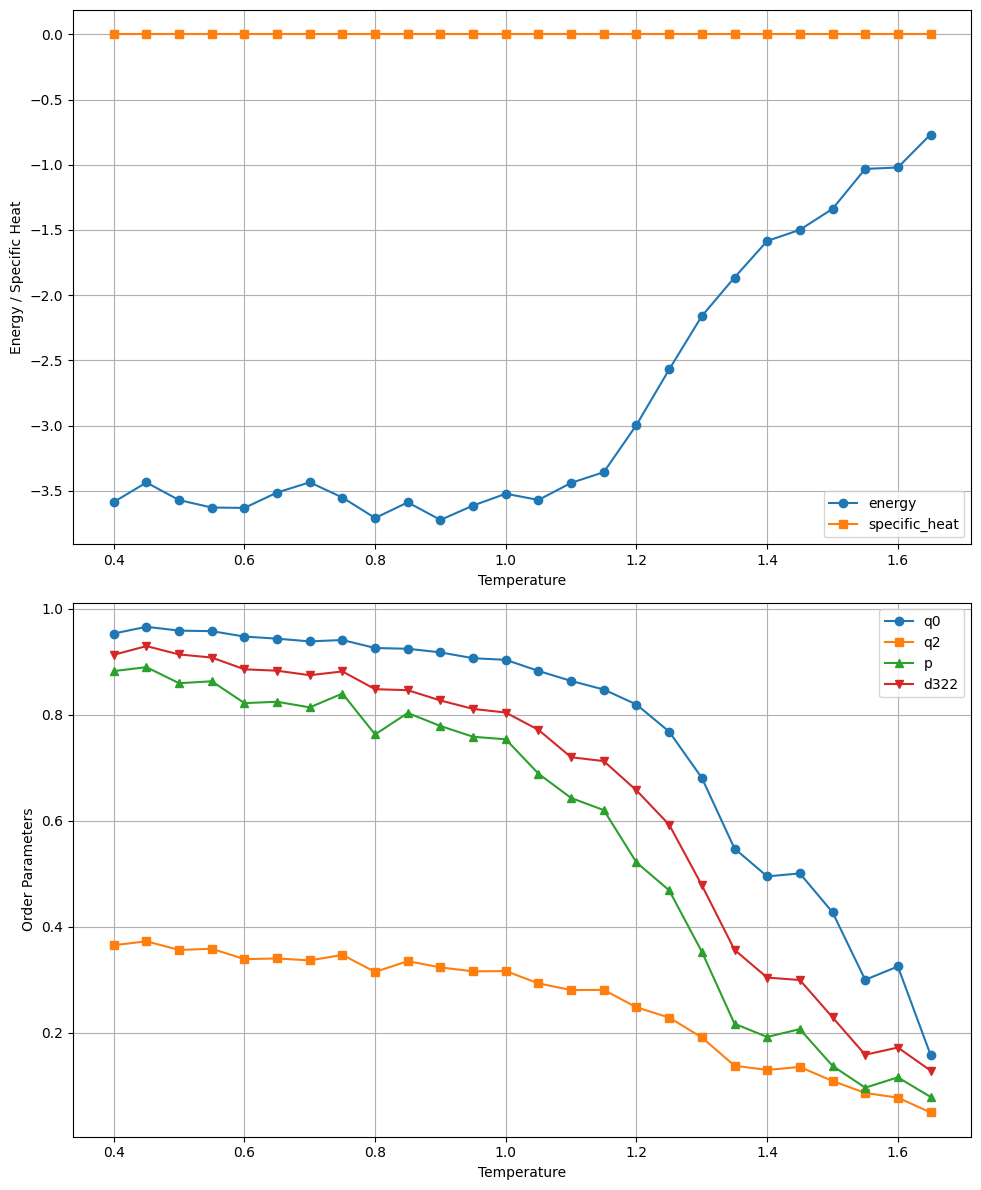

In [ ]:
# Display the current state of the plots
# plotter.show_current_state()

# Uncomment the line below to start live updates every 2 seconds
plotter.start_live_updates(update_interval=2.0)

# To stop live updates, uncomment:
# plotter.stop_live_updates()

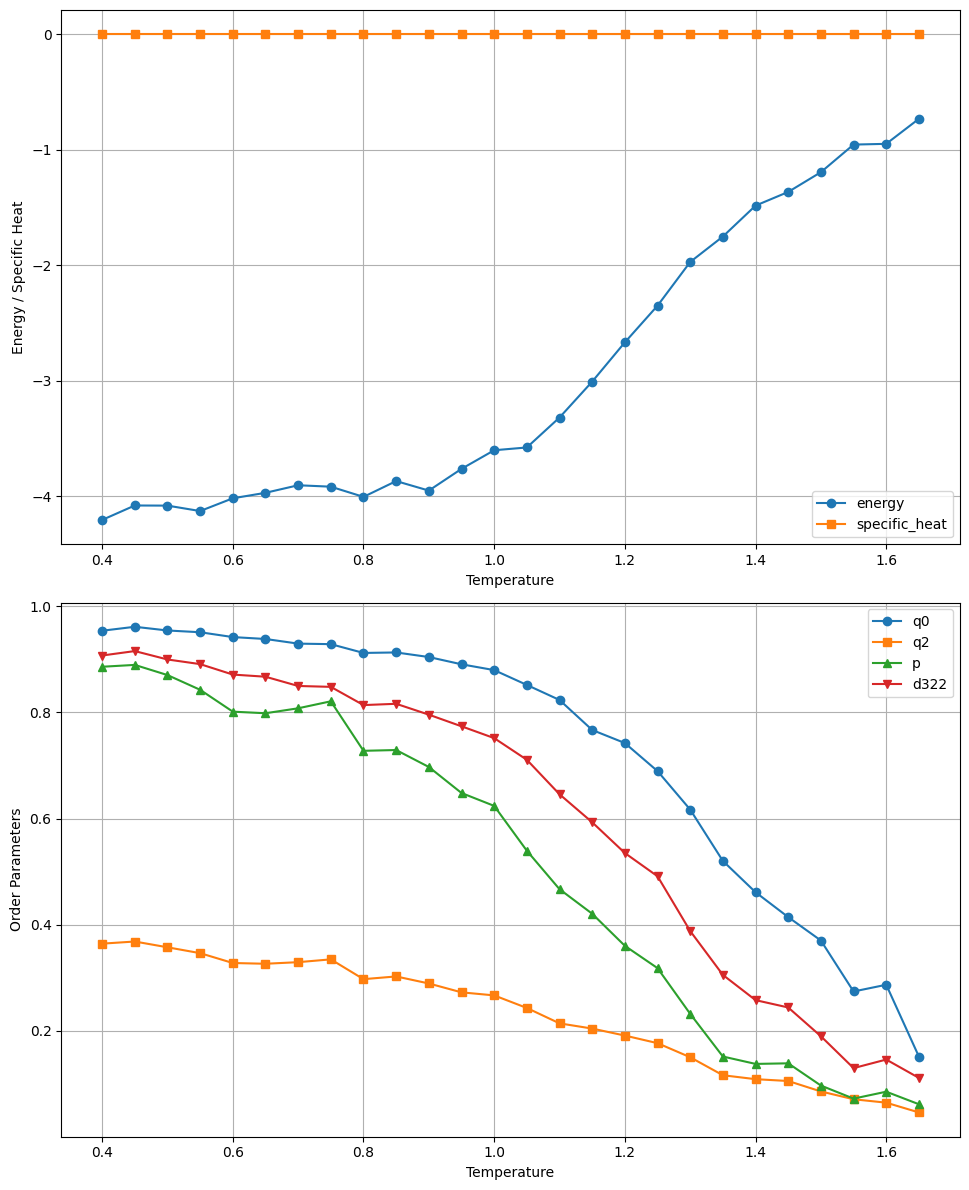

In [11]:
## uncomment to stop the simulation
runner.stop()